# Model architecture

<img src="U-net Architecture-picture.png" />

# Packages required

In [1]:
import sys
import random
import os
import numpy as np #Linear algebra 
import SimpleITK as sitk # image processing
import matplotlib.pyplot as plt # Visualisation

In [2]:
from keras import regularizers
from keras.layers import BatchNormalization as BatchNorm
from keras.models import Model, load_model
from keras.layers import Input, Reshape, Activation
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import layers

Using TensorFlow backend.


# Processing data part :

   ## -*Extract,randomize,normalize*

   ## -*Check the images to see if everything went as planned*

   ## -*Create a function to give input ready data to model*


In [3]:
def randomize(image,label):
    """Purpose: shuffle the npa image and his label
    
        Args:
            image: npa representing the [depth,height,weight]
            label: npa [depth,height,weight]
            
        
        Return:
            
            suffle_image:  npa representing the suffled image [depth,height,weight]
            suffle_label:  npa [depth,height,weight]
    """
    permutation = np.random.permutation(image.shape[0])
    
    suffle_image = image[permutation]
    suffle_label = label[permutation]
    
    return suffle_image,suffle_label

In [4]:
def get_data(data_dir,num_subjects,mode,valid_id,pred_id):
    
    """Purpose:
    
        Args:
            data_dir: data director containing your data
            num_sbjects: int the numbers of patient that your dataset contain
            mode: string, train or pred or valid to specify the nature of your data 
            valid_id: int, the patient that wil be insigned for validation
            pred_id: int,the patient that will be insigned for prediction 
        
        Return:
            images_np: complete image data for training or validation or prediction
            labels_np: complete image data for training or validation or prediction
    """
    images_np=[]
    labels_np=[]
    
    
    if mode=='train':
        subjects_file = [os.path.join(data_dir,'HeadAndNeck_anonymous-%d' %p) for p in range(1,num_subjects+1) if p!= valid_id and p!= pred_id]
    
    elif mode=='pred':
        subjects_file = [os.path.join(data_dir,'HeadAndNeck_anonymous-%d' %pred_id)]  
        
    else:
        subjects_file = [os.path.join(data_dir,'HeadAndNeck_anonymous-%d' %valid_id)]

    for url in subjects_file:
        image=sitk.ReadImage(url+'.mha')
        max_index=image.GetDepth()-1
        list_of_2D_images=[sitk.GetArrayFromImage(image[:,:,i]) for i in range(max_index)]
        images_np=list_of_2D_images+images_np
        
        label=sitk.ReadImage(url+'-label.mha')
        max_index=label.GetDepth()-1
        list_of_2D_labels=[sitk.GetArrayFromImage(label[:,:,i]) for i in range(max_index)]
        labels_np=list_of_2D_labels+labels_np
        
    images_np=np.array(images_np)
    labels_np=np.array(labels_np)
        
    return images_np/np.max(images_np),labels_np
        
        
       
            

*Check if the images and the labels are correct*

In [ ]:
data_dir=r"D:\data"
num_subjects=11
mode='train'
valid_id=3
pred_id=5
test_image,test_label=get_data(data_dir,num_subjects,mode,valid_id,pred_id)

In [ ]:
valid_id=3
pred_id=5
data_dir=r"D:\data"
subjects_file = [os.path.join(data_dir,'HeadAndNeck_anonymous-%d' %p) for p in range(1,num_subjects+1) if p!= valid_id and p!=pred_id]

In [ ]:
r = random.randint(0, len(test_image-1))
fig,axes = plt.subplots(1,2,figsize=(20,10))

axes[0].imshow(test_image[r])
axes[0].set_title('CT image %i'%r)
axes[1].imshow(test_label[r])
axes[1].set_title('Groundtruth slice %i'%r)

print(test_image.shape,test_label.shape)

In [210]:
def data_generator(data_dir,num_subjects,mode,valid_id,pred_id,shuffle=True):
    """Purpose:
    
        Args:
            data_dir:data director containing your data
            num_sbjects: int the numbers of patient that your dataset contain
            mode: "train","pred","valid" 
            valid_id: int, the patient that wil be insigned for validation
            pred_id: int,the patient that will be insigned for prediction 
            shuffle: bool, set to True if you want to shuffle the data
        
        Return:
            
            
    """
    images,labels=get_data(data_dir,num_subjects,mode,valid_id,pred_id)
    if shuffle:
        shuffle_image,shuffle_label=randomize(images,labels)
        
        return shuffle_image[:,:,:,np.newaxis],shuffle_label[:,:,:,np.newaxis] 
        
    else:
        
        return images[:,:,:,np.newaxis],labels[:,:,:,np.newaxis]
    
        

In [ ]:
data_dir=r"D:\xxx_gathering_augmented"
num_subjects=16
mode='train'
valid_id=3
image,label=data_generator(data_dir,num_subjects,mode,valid_id,shuffle=True)

## Definition of the core blocks for building model architecture

In [6]:
def downsampling(x, level, filters, kernel_size, num_convs, conv_strides=1, activation = 'relu', batch_norm = False, pool_size = 2, pool_strides = 2, regularizer = None, regularizer_param = 0.001):
    if regularizer is not None:
        if regularizer == 'l2':
            reg = regularizers.l2(regularizer_param)
        elif regularizer == 'l1':
            reg = regularizers.l1(regularizer_param)
    else:
        reg = None
    for i in range(num_convs):
        x = Conv2D(filters=filters, kernel_size=kernel_size, strides=conv_strides, padding='same', kernel_regularizer=reg, bias_regularizer=reg, name = 'downsampling_' + str(level) + '_conv_' + str(i))(x)
        if batch_norm:
            x = BatchNorm(name = 'downsampling_' + str(level) + '_batchnorm_' + str(i))(x)
        x = Activation(activation, name = 'downsampling_' + str(level) + '_activation_' + str(i))(x)
    skip = x
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    return x, skip




def bottleneck_dilated(x, filters, kernel_size, num_convs = 6, activation = 'relu', batch_norm = False, last_activation = False, regularizer = None, regularizer_param = 0.001):
#     assert num_convs == len(conv_strides)
    if regularizer is not None:
        if regularizer == 'l2':
            reg = regularizers.l2(regularizer_param)
        elif regularizer == 'l1':
            reg = regularizers.l1(regularizer_param)
    else:
        reg = None
    skips = []
    for i in range(num_convs):
        x = Conv2D(filters=filters, kernel_size=kernel_size, strides=1, dilation_rate = 2 ** i, activation='relu', padding='same', kernel_regularizer=reg, bias_regularizer=reg, name = 'bottleneck_skip_' + str(i))(x)
        skips.append(x)
    x = layers.add(skips)
    if last_activation:
        x = Activation('relu')(x)
    return x





def bottleneck(x, filters, kernel_size, num_convs, conv_strides=1, activation = 'relu', batch_norm = False, pool_size = 2, pool_strides = 2, regularizer = None, regularizer_param = 0.001):
    if regularizer is not None:
        if regularizer == 'l2':
            reg = regularizers.l2(regularizer_param)
        elif regularizer == 'l1':
            reg = regularizers.l1(regularizer_param)
    else:
        reg = None
    for i in range(num_convs):
        x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', kernel_regularizer=reg, bias_regularizer=reg, name = 'bottleneck_' + str(i))(x)
        if batch_norm:
            x = BatchNorm()(x)
        x = Activation(activation)(x)
    return x






def upsampling(x, level, skip, filters, kernel_size, num_convs, conv_strides=1, activation = 'relu', batch_norm = False, conv_transpose = True, upsampling_size = 2, upsampling_strides = 2, regularizer = None, regularizer_param = 0.001):
    if regularizer is not None:
        if regularizer == 'l2':
            reg = regularizers.l2(regularizer_param)
        elif regularizer == 'l1':
            reg = regularizers.l1(regularizer_param)
    else:
        reg = None
    if conv_transpose:
        x = Conv2DTranspose(filters=filters, kernel_size = upsampling_size, strides=upsampling_strides, name = 'upsampling_' + str(level) + '_conv_trans_' + str(level))(x)
    else:
        x = UpSampling2D((upsampling_size), name = 'upsampling_' + str(level) + '_ups_' + str(i))(x)
    x = Concatenate()([x, skip])
    for i in range(num_convs):
        x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', kernel_regularizer=reg, bias_regularizer=reg, name = 'upsampling_' + str(level) + '_conv_' + str(i))(x)
        if batch_norm:
            x = BatchNorm(name = 'upsampling_' + str(level) + '_batchnorm_' + str(i))(x)
        x = Activation(activation, name = 'upsampling_' + str(level) + '_activation_' + str(i))(x)
    return x









In [7]:
def model_simple_unet(num_classes, num_levels, num_layers = 2, num_bottleneck = 2, filter_size_start = 16, batch_norm = False, kernel_size = 3, bottleneck_dilation = False, bottleneck_sum_activation = False, regularizer = None, regularizer_param = 0.001):
    """ purpose: 
        
        Args:
        
        
        Returns:
        
        
        """
    
    
    
    
    inputs = Input((img_shape))
    x = inputs
    skips = []
    #Down-samping block
    for i in range(num_levels):
        x, skip = downsampling(x, i, filter_size_start * (2 ** i), kernel_size, num_layers, batch_norm=True, regularizer= regularizer, regularizer_param=regularizer_param)
        skips.append(skip)
        
    #Bottleneck    
    if bottleneck_dilation:
        x = bottleneck_dilated(x, filter_size_start * (2 ** num_levels), kernel_size, num_bottleneck, batch_norm=True, last_activation=bottleneck_sum_activation, regularizer= regularizer, regularizer_param=regularizer_param)
    else:
        x = bottleneck(x, filter_size_start * (2 ** num_levels), kernel_size, num_bottleneck, batch_norm=True, regularizer=regularizer, regularizer_param=regularizer_param)
    
    
    #Up-sampling block
    for j in range(num_levels):
        x = upsampling(x, j, skips[num_levels - j - 1], filter_size_start * (2 ** (num_levels - j - 1)), kernel_size, num_layers, batch_norm=True, regularizer= regularizer, regularizer_param=regularizer_param)
    outputs = Conv2D(filters=num_classes, kernel_size=1, strides=1, padding='same', activation='softmax', name = 'output_softmax')(x)
    
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=[dice_coef])
    model.summary()
    return model




In [8]:
def model_train(model, x_train, y_train,x_valid,y_valid,epochs, early_stopper, patience_lr, model_name):
    """Purpose:
    
        Args: 
            model:
            x_train:
            y_train:
            x_valid:
            y_valid:
            epochs:
            early_stopper:
            patience_lr:
            model_name:
        
        Return:
            model:
            results:
    """
    early_stopper = EarlyStopping(patience=early_stopper, verbose=1)
    reduce_learning_rate = ReduceLROnPlateau(monitor='loss', factor = 0.75, patience = patience_lr, verbose=1)
    checkpointer = ModelCheckpoint(model_name + '.h5', verbose=1, save_best_only=True)
    checkpointer_train = ModelCheckpoint(model_name + 'best_train_all_data_augmented.h5', monitor='loss', verbose=1, save_best_only=True)
    results = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=5, epochs=epochs, callbacks=[early_stopper, checkpointer, checkpointer_train, reduce_learning_rate])
    return model, results

In [9]:
def dice_coef(y_true, y_pred, smooth=1):
    """Purpose:
    
        Args:
            y_true:
            
            y_pred:
        
        Return: 
            The dice coefficient of 
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)



# *Hyperparamters setting for model initialisation*

In [10]:
img_height = 512
img_width = 512
num_channels = 1
img_shape = (img_height, img_width, num_channels)
num_classes = 39

In [11]:
model_test=model_simple_unet(num_classes, num_levels=4 , num_layers = 2, num_bottleneck = 2, filter_size_start = 16, batch_norm = False, kernel_size = 3, bottleneck_dilation = False, bottleneck_sum_activation = False, regularizer = 'l2', regularizer_param = 0.001)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
downsampling_0_conv_0 (Conv2D)  (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
downsampling_0_batchnorm_0 (Bat (None, 512, 512, 16) 64          downsampling_0_conv_0[0][0]      
__________________________________________________________________________________________________
downsampling_0_activation_0 (Ac (None, 512, 512, 16) 0           downsampling_0_batchnorm_0[0][0] 
_____________________________________

# Split the dataset into train, validation set

In [12]:
data_dir=r"D:\data_set_no_augmentation"
num_subjects=8
mode='train'
pred_id=5
valid_id=3
x_train,y_train=data_generator(data_dir,num_subjects,mode,valid_id,pred_id,shuffle=True)


In [13]:
data_dir=r"D:\data_set_no_augmentation"
num_subjects=8
mode='valid'
valid_id=3
pred_id=5
x_valid,y_valid=data_generator(data_dir,num_subjects,mode,valid_id,pred_id,shuffle=True)

In [14]:
print(x_valid.shape,y_valid.shape,x_train.shape,y_train.shape)

(136, 512, 512, 1) (136, 512, 512, 1) (1140, 512, 512, 1) (1140, 512, 512, 1)


In [ ]:
np.unique(y_train)

In [15]:
model1, results1 = model_train(model_test, x_train, y_train,x_valid,y_valid,100, 100, 6,'model_all_data_30epochs')

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1140 samples, validate on 136 samples
Epoch 1/100
1140/1140 [==============================] - 72s 63ms/step - loss: 2.0686 - dice_coef: 0.8856 - val_loss: 0.7698 - val_dice_coef: 0.7352

Epoch 00001: val_loss improved from inf to 0.76978, saving model to model_all_data_30epochs.h5

Epoch 00001: loss improved from inf to 2.06860, saving model to model_all_data_30epochsbest_train_all_data_augmented.h5
Epoch 2/100
1140/1140 [==============================] - 60s 53ms/step - loss: 0.3166 - dice_coef: 0.5788 - val_loss: 0.2265 - val_dice_coef: 0.5327

Epoch 00002: val_loss improved from 0.76978 to 0.22648, saving model to model_all_data_30epochs.h5

Epoch 00002: loss improved from 2.06860 to 0.31655, saving model to model_all_data_30epochsbest_train_all_data_augmented.h5
Epoch 3/100
1140/1140 [==============================] - 61s 54ms/step - loss: 0.1483 -

# load the patient to make the prediction on

In [16]:
data_dir=r"D:\data_set_no_augmentation"
num_subjects=8
mode='pred'
valid_id=3
pred_id=5
x_pred,y_pred=data_generator(data_dir,num_subjects,mode,valid_id,pred_id,shuffle=True)

In [17]:
np.unique(y_pred)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38], dtype=int16)

In [18]:
## Save the Weights
model1.save_weights("UNetW.h5_model_all_data_30epochs")



In [19]:
x,y=x_pred,y_pred


In [20]:
result = model1.predict(x) #segmented map in the class space

In [21]:
prediction=np.argmax(result,axis=-1) #semgented map in dimension image space

In [22]:
np.unique(prediction) # hecking the labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37], dtype=int64)

# Visualisation the prediction

Classes present in the groundtruth slice 136 [0 1]
Classes present in the prediction slice 136 [0 1 2]


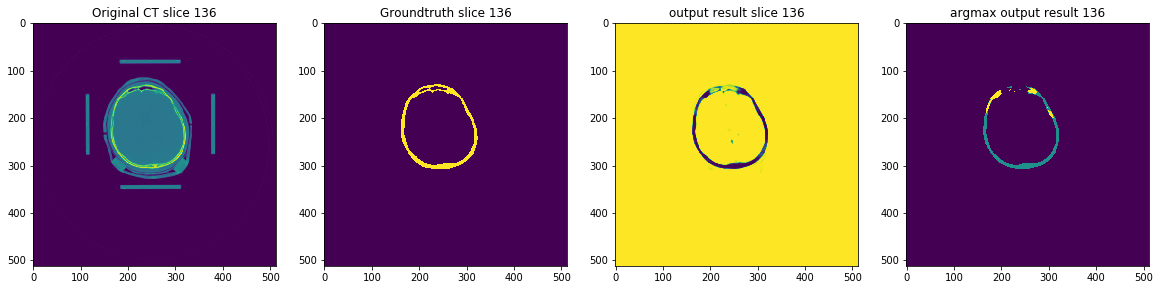

In [30]:
r = random.randint(0, len(y)-1)
fig,axes = plt.subplots(1,4,figsize=(20,10))

axes[0].imshow(x[r,:,:,0])
axes[1].imshow(y[r,:,:,0])
axes[2].imshow(result[r,:,:,0])
axes[3].imshow(prediction[r])
axes[0].set_title("Original CT slice %i"%r)
axes[1].set_title("Groundtruth slice %i"%r)
axes[2].set_title("output result slice %i"%r)
axes[3].set_title("argmax output result %i"%r)
print("Classes present in the groundtruth slice %i" %r,np.unique(y[r,:,:,0]))
print("Classes present in the prediction slice %i"%r,np.unique(prediction[r]))


In [ ]:
result.shape

In [ ]:
np.unique(argmax_result)

In [ ]:
# Plot training & validation accuracy values
plt.plot(results1.history['dice_coef'])
plt.plot(results1.history['val_dice_coef'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(results1.history['loss'])
plt.plot(results1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Reload the model

In [276]:
model=load_model(r"C:\Users\r778e\Desktop\KnowUbone\model_all_data_and_PM_Aug_100epochsbest_train_all_data_augmented.h5",custom_objects={'dice_coef': dice_coef})

In [277]:
model.load_weights("UNetW.h5_model_all_data_and_PM_Aug_100epochs")

In [278]:
data_dir=r"D:\data_set_PM_augmentation"
num_subjects=16
mode='pred'
valid_id=3
pred_id=5
x_pred,y_pred=data_generator(data_dir,num_subjects,mode,valid_id,pred_id,shuffle=False)

In [279]:
x,y=x_pred,y_pred

In [280]:
print(x_pred.shape,y_pred.shape)

(156, 512, 512, 1) (156, 512, 512, 1)


In [281]:
result=model.predict(x)

In [282]:
result = np.argmax(result, axis=-1)


In [283]:
np.unique(result)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34,
       35, 36, 37], dtype=int64)

[ 0  3  4  5  6  9 18 19 21 22 24 25 27 28 29 30 31 32 33 34]
[ 0  1  2  3  4  5  6  8  9 10 11 17 18 19 20 22 23 24 25 26 27 28 30 31
 33 34 35 36 37]


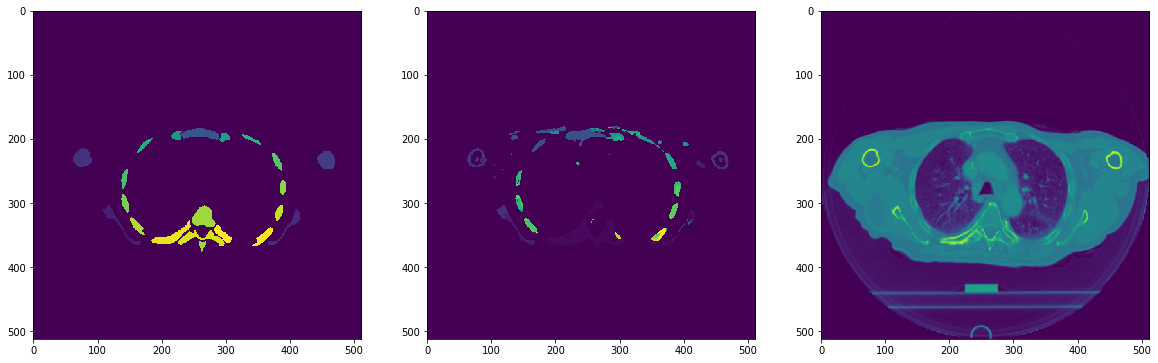

In [294]:
r = random.randint(0, len(y)-1)
fig,axes = plt.subplots(1,3,figsize=(20,10))

axes[0].imshow(y[r,:,:,0])
print(np.unique(y[r,:,:,0]))

axes[1].imshow(result[r])
print(np.unique(result[r]))

axes[2].imshow(x[r,:,:,0])

In [295]:
save_dir=r"C:\Users\r778e\Desktop\Results"
save_filename="2D_prediction_patient_5_from_baseline_PMaug"
save_file = os.path.join(save_dir, save_filename)
np.save(save_file, result)

In [7]:
filename=r"C:\Users\r778e\Desktop\Results\2D_prediction_patient_5_from_baseline+Typaug.npy"
prediction=np.load(filename)

# Save the prediction into mha file and npa for analysis purpose

In [3]:
def convert_npa_to_mha_and_npa(prediction,id_patient,output_dir):
    
    """Purpose: convert the npa prediction to the conform mha file.
    
        Args:
            prediction:
            id_patient:
            outputdir_dir:
    
        
        
    """
    
    npa_res=prediction.astype('int16')
    res_img = sitk.GetImageFromArray(npa_res)
    
    npa_zeros=np.zeros([512,512],'int16')
    npa_zeros=npa_zeros[np.newaxis,:,:]
    
    filename_ground_truth=r"D:\xxx_gathering_augmented\HeadAndNeck_anonymous-%i.mha" %id_patient
    ground_truth = sitk.ReadImage(filename_ground_truth)
    
    if len(res_img) == ground_truth.GetDepth():
        res_img.CopyInformation(ground_truth)
        sitk.WriteImage(res_img,os.path.join(output_dir,"prediction_from_patient_%i.mha"%id_patient))
        
        print('Done.')
        print('The prediction has been succesfuly converted to mha file')
    
    else:
        npa_res=np.concatenate((npa_res,npa_zeros),axis=0)
        res_img = sitk.GetImageFromArray(npa_res)
        res_img.CopyInformation(ground_truth)
        sitk.WriteImage(res_img,os.path.join(output_dir,"prediction_from_patient_%i.mha"%id_patient))
       
        print('Done.')
        print('The prediction has been succesfuly converted to mha file and npa file')
    

In [8]:
id_patient=5
output_dir=r"C:\Users\r778e\Desktop\Tutorial"
convert_npa_to_mha_and_npa(prediction,id_patient,output_dir)

Done.
The prediction has been succesfuly converted to mha file and npa file
